# FRA 503: Deep Reinforcement Learning
# Homework 1

## Part 1: Setting up Multi-armed Bandit.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#### Bandit Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - hidden reward distributions สำหรับแต่ละ bandit (0-1 แทนโอกาสได้รางวัล 0-100%) 
2.  ฟังชั่น get_reward 
    - รับ bandit_index เพื่อระบุ Bandit ที่ถูกเลือก
    - สุ่มค่าโดยอิงตาม rate ที่กำหนดใน hidden reward distributions ถ้าถูกรางวัลจะ return 1 ไม่ถูกจะ return 0

In [3]:
import numpy as np

class Bandit:
    def __init__(self, n_bandits, custom_rewards=None):
        # จำนวน Bandits
        self.n_bandits = n_bandits

        if custom_rewards is None:
            # สร้าง hidden reward distributions สำหรับแต่ละ bandit (สุ่มค่าความน่าจะเป็นระหว่าง 0 ถึง 1)
            self.reward_distributions = np.random.uniform(0, 1, self.n_bandits)
        else:
            # print(len(custom_rewards),n_bandits)
            if len(custom_rewards) == n_bandits:
                # ใช้ custom rewards ที่ผู้ใช้ให้มา
                self.reward_distributions = np.array(custom_rewards)
            else:
                raise ValueError("Custom rewards must be an array of length equal to n_bandits.")

    def get_reward(self, bandit_index):
        if 0 <= bandit_index < self.n_bandits:
            # สุ่มรางวัล: 1 (ถูกรางวัล) หรือ 0 (ไม่ถูกรางวัล) ตามความน่าจะเป็น
            return 1 if np.random.rand() < self.reward_distributions[bandit_index] else 0
        else:
            raise ValueError("Bandit index out of range!")



#### Agent Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - Learning Rate
    - Q-value
    - ค่าคงที่สำหรับ UCB
    - จำนวน timestep ทั้งหมด
    - action_probs ความน่าจะเป็นในการเลือกครั้งแรกจะเท่ากันทุก  bandit


2. ฟังชั่น select_action ใช้ในการเลือก bandits โดยตั้งต้นจะให้ใช้ UCB 
    - Epsilon-Greedy 
        
        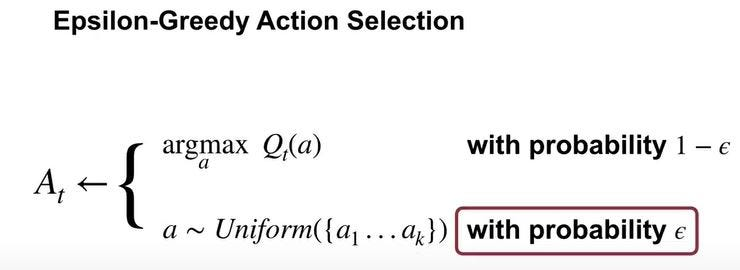

        
    - Upper Confidence Bound (UCB)
        
        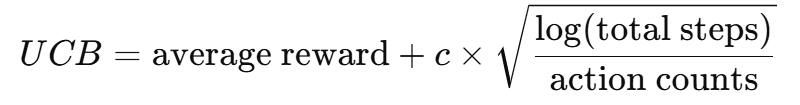



3. ฟังชั่น update




In [4]:
class Agent:
    def __init__(self, n_bandits ,c =2 , epsilon = 0.5):
        #จำนวน bandits
        self.n_bandits = n_bandits 
        # เริ่มต้นค่าประมาณการรางวัล (Q-value) และ policy (action distribution)
        self.q_values = np.zeros(n_bandits) 
        
        #Upper Confidence Bound (UCB)
        self.c = c  # ค่าคงที่สำหรับ UCB  
        self.total_steps = 0  # จำนวน timestep ทั้งหมด
        self.action_counts = np.zeros(n_bandits)  # จำนวนครั้งที่เลือกแต่ละ Bandit
        
        #Epsilon-Greedy
        self.epsilon = epsilon  # ค่า Epsilon สำหรับ Epsilon-Greedy
    
    def select_action_UCB(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Upper Confidence Bound (UCB)
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1
        ucb_values = np.zeros(self.n_bandits)
        
        for i in range(self.n_bandits):
            if self.action_counts[i] > 0:
                # ปรับสูตรความมั่นใจ (เพิ่ม +1 ในตัวหารเพื่อป้องกันหารด้วย 0)
                confidence = self.c * np.sqrt(np.log(self.total_steps) / (self.action_counts[i]))
                ucb_values[i] = self.q_values[i] + confidence
            else:
                # เลือก Bandit ที่ยังไม่เคยถูกเลือก
                return i
        
        # เลือก Bandit ที่มีค่า UCB สูงสุด
        return np.argmax(ucb_values)
    
    def select_action_epsilon_greedy(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Epsilon-Greedy
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1

        if np.random.rand() < self.epsilon:
            # Exploration: เลือก Bandit แบบสุ่ม
            return np.random.randint(0, self.n_bandits)
        else:
            # Exploitation: เลือก Bandit ที่มีค่า Q-value สูงสุด
            return np.argmax(self.q_values)
        
    
    def update(self, action, reward):
        """
        อัปเดต Q-value และจำนวนครั้งที่เลือก Bandit
        :param action: ดัชนีของ Bandit ที่เลือก
        :param reward: รางวัลที่ได้รับจาก Bandit นั้น
        """
        self.action_counts[action] += 1
        # อัปเดต Q-value แบบ incremental
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

In [25]:
def run_experiment(n_bandits, n_steps, c=2, epsilon=0.5, method="UCB",custom_rewards=None):
    # print(f"custom_rewards at start: {custom_rewards}")  # Debug print
    bandit = Bandit(n_bandits,custom_rewards)
    agent = Agent(n_bandits, c, epsilon)

    rewards = []
    cumulative_rewards = []
    actions_selected = []

    for step in range(n_steps):
        # เลือกฟังก์ชันการเลือก Bandit ตาม method ที่กำหนด
        if method == "UCB":
            action = agent.select_action_UCB()
        elif method == "Epsilon-Greedy":
            action = agent.select_action_epsilon_greedy()
        else:
            raise ValueError("Invalid method. Choose 'UCB' or 'Epsilon-Greedy'.")

        # รับรางวัลจาก Bandit
        reward = bandit.get_reward(action)

        # อัปเดต Q-value และจำนวนครั้งที่เลือก
        agent.update(action, reward)

        # เก็บรางวัลและคำนวณรางวัลสะสมเฉลี่ย
        rewards.append(reward)
        cumulative_rewards.append(np.mean(rewards))
        actions_selected.append(action)
        # print(action)

    return rewards, cumulative_rewards, bandit.reward_distributions, actions_selected


## Generate a random reward and see how algorithm act.

#### First, we will use a UCB Algorithm and set a n_bandits to 5, n_steps = 1000, c = 1. 

Hidden reward distributions: [0.5848687  0.8967036  0.78503461 0.64135918 0.1924235 ]
Maximum Possible Reward : 0.8967036031136311
Average reward after 1000 steps using UCB: 0.85


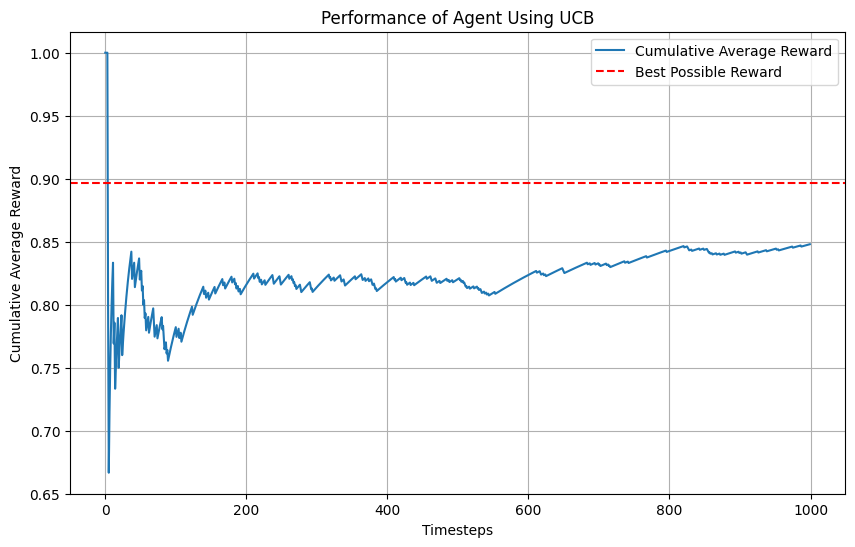

In [24]:
if __name__ == "__main__":
    n_bandits = 5     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    c = 1             # ค่า UCB ค่าคงที่สำหรับ Exploration
    epsilon = 0.1     # ค่า Epsilon สำหรับ Epsilon-Greedy
    rewards = None    # make it random

    # เลือกวิธีการทดลอง
    method ="UCB"

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(
        n_bandits=n_bandits,
        n_steps=n_steps,
        c=c,
        epsilon=epsilon,
        method=method,
        custom_rewards=rewards
    )

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Maximum Possible Reward : {max(hidden_rewards)}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


#### Then, we will set a n_bandits to 10. 

Hidden reward distributions: [0.66130328 0.49565106 0.12599027 0.57715621 0.16537129 0.50897837
 0.9784453  0.77645298 0.66083997 0.98377325]
Maximum Possible Reward : 0.9837732480844471
Average reward after 1000 steps using UCB: 0.90


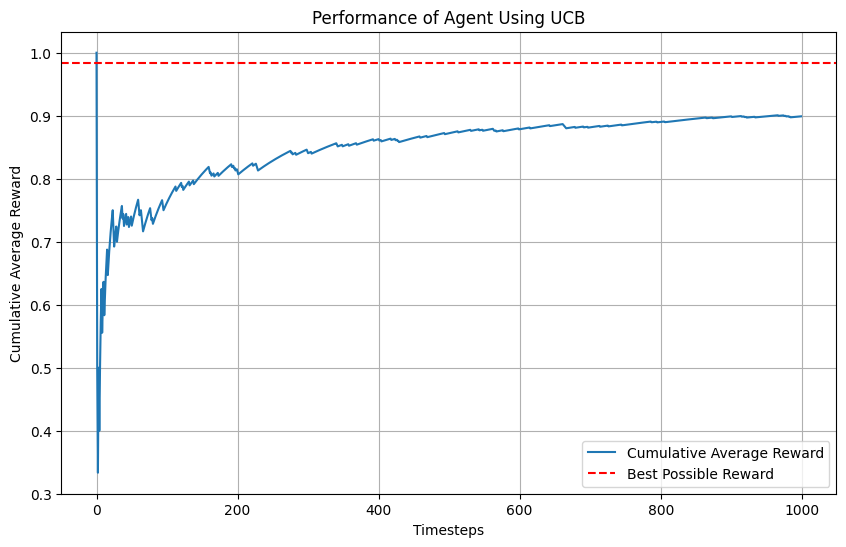

In [33]:
if __name__ == "__main__":
    n_bandits = 10     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    c = 1             # ค่า UCB ค่าคงที่สำหรับ Exploration
    epsilon = 0.1     # ค่า Epsilon สำหรับ Epsilon-Greedy
    rewards = None    # make it random

    # เลือกวิธีการทดลอง
    method ="UCB"

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(
        n_bandits=n_bandits,
        n_steps=n_steps,
        c=c,
        epsilon=epsilon,
        method=method,
        custom_rewards=rewards
    )

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Maximum Possible Reward : {max(hidden_rewards)}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


## Part 2: Implementing epsilon-greedy algorithm.

epsilon = 0.01: Average reward = 0.80
epsilon = 0.1: Average reward = 0.76
epsilon = 0.5: Average reward = 0.57
epsilon = 1: Average reward = 0.35
Hidden reward distributions: [0.8  0.15 0.2  0.5  0.1 ]


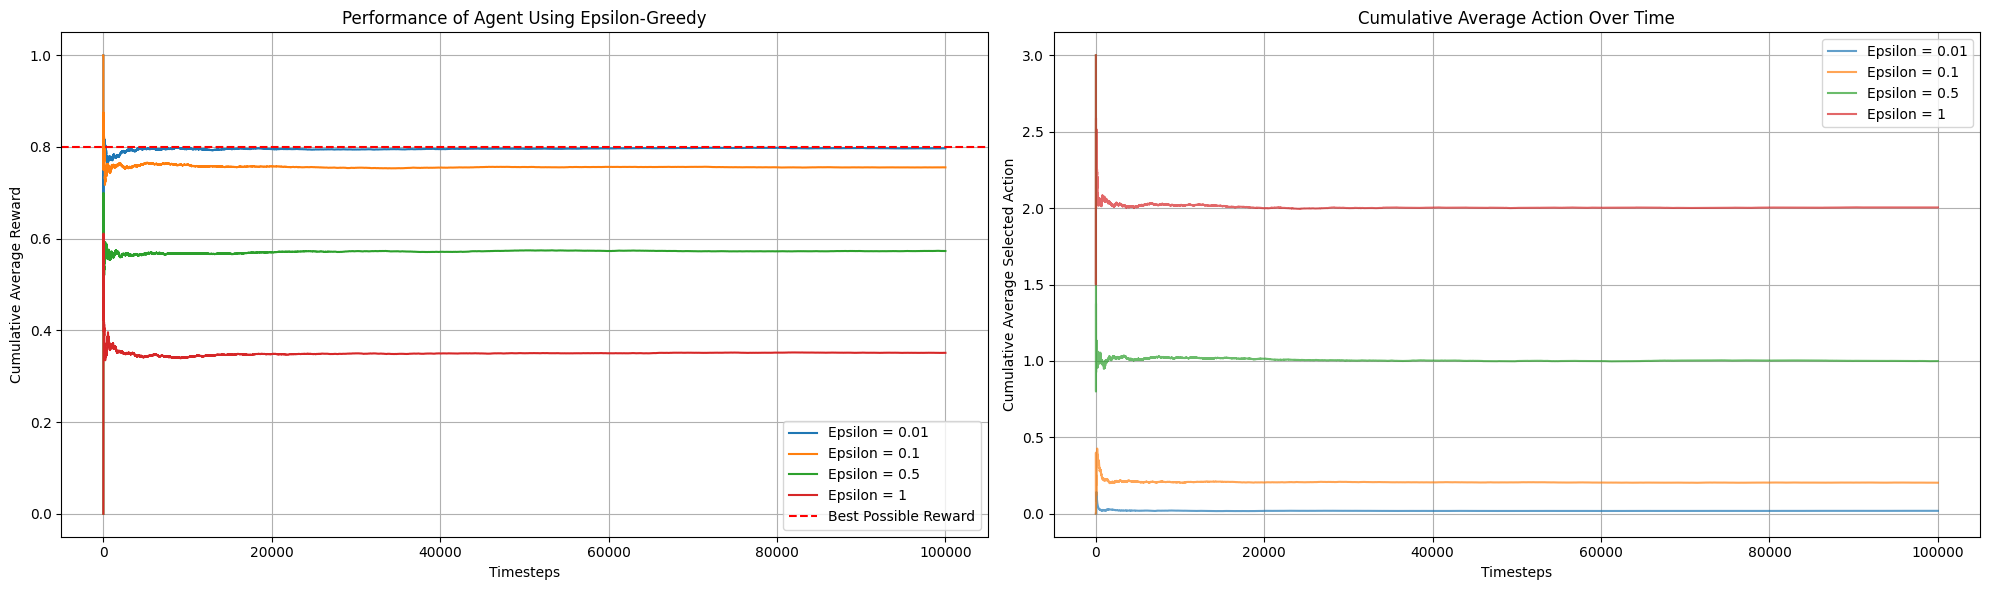

In [46]:
if __name__ == "__main__":

    cumulative_rewards_results = {}
    actions_selected_results = {}

    n_bandits = 5     # Number of Bandits
    n_steps = 10000    # Number of Timesteps
    epsilon_values = [0.01, 0.1, 0.5, 1]
    rewards = [0.8, 0.15, 0.2, 0.5, 0.1] 

    method = "Epsilon-Greedy"  

    for epsilon in epsilon_values:
        rewards = [0.8, 0.15, 0.2, 0.5, 0.1] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[epsilon] = cumulative_rewards
        actions_selected_results[epsilon] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    print(f"Hidden reward distributions: {hidden_rewards}")

    # --- Plot Cumulative Rewards ---
    for epsilon, cumulative_rewards in cumulative_rewards_results.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"Epsilon = {epsilon}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for epsilon, actions_selected in actions_selected_results.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"Epsilon = {epsilon}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()




## Experimental 
### hypothesize
### 1. If epsilon approaches 0, the agent will fail to explore sufficiently and may not find the most rewarded bandit.
### 2. If epsilon approaches 1, the agent will continuously observe (exploit) the bandits without sufficient exploration, also failing to find the most rewarded bandit.
### Observation : We analyzed the average reward for each epsilon value over 10 trials and observed the trend of the graph.

### We conducted an experiment by running an epsilon-greedy algorithm with the following epsilon values: [0.01, 0.1, 0.5, 1]. Each value was tested ten times, and the rewards were fixed for five bandits with the following probabilities: [0.1, 0.15, 0.2, 0.5, 0.8]. Here are the results.

### 1st run

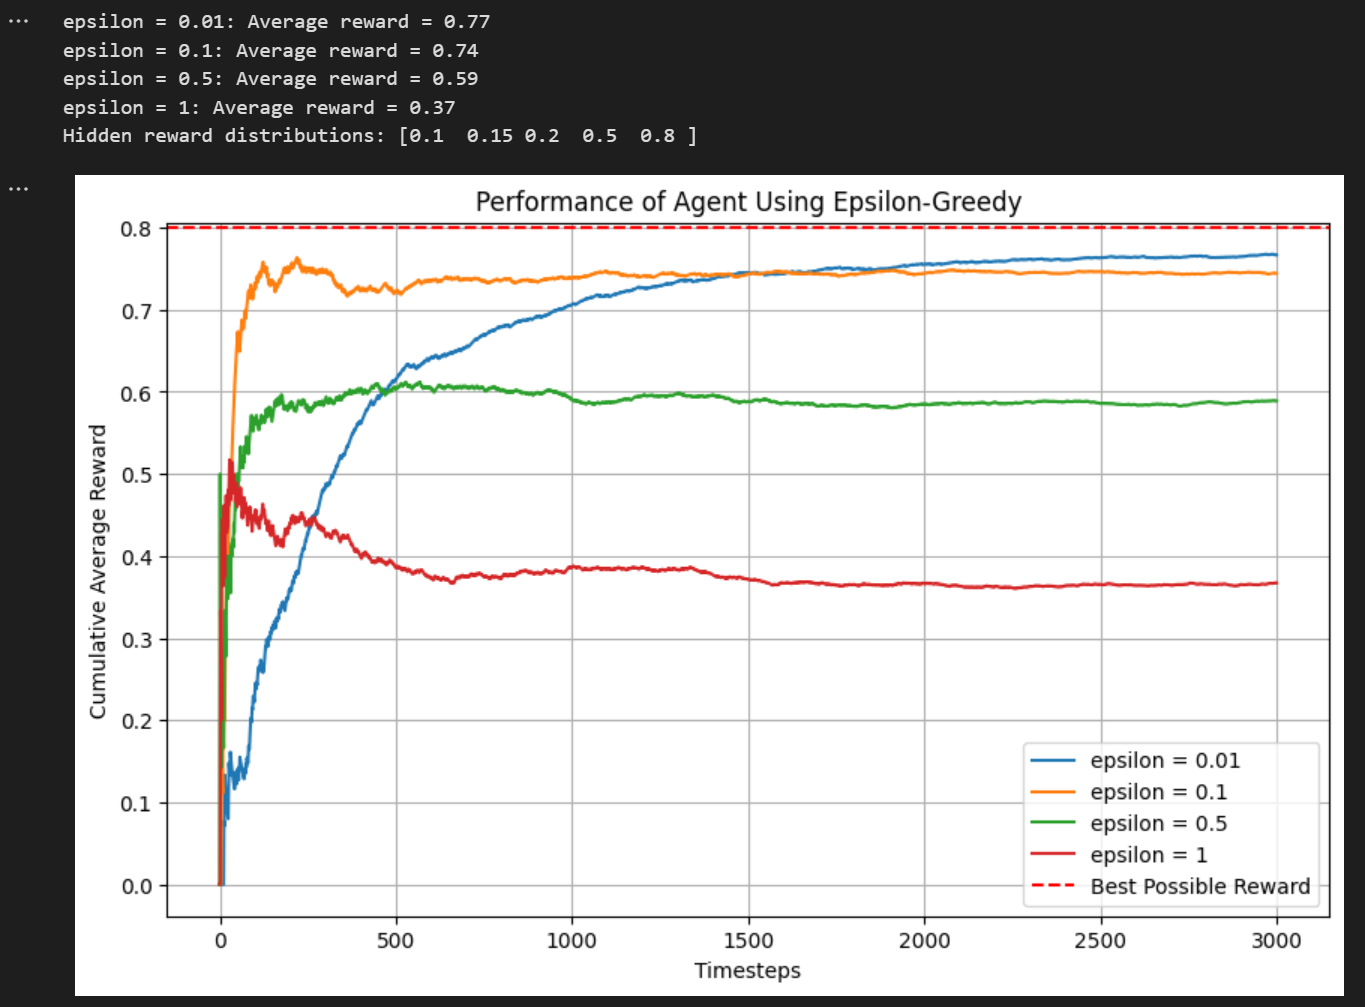

### 2nd run

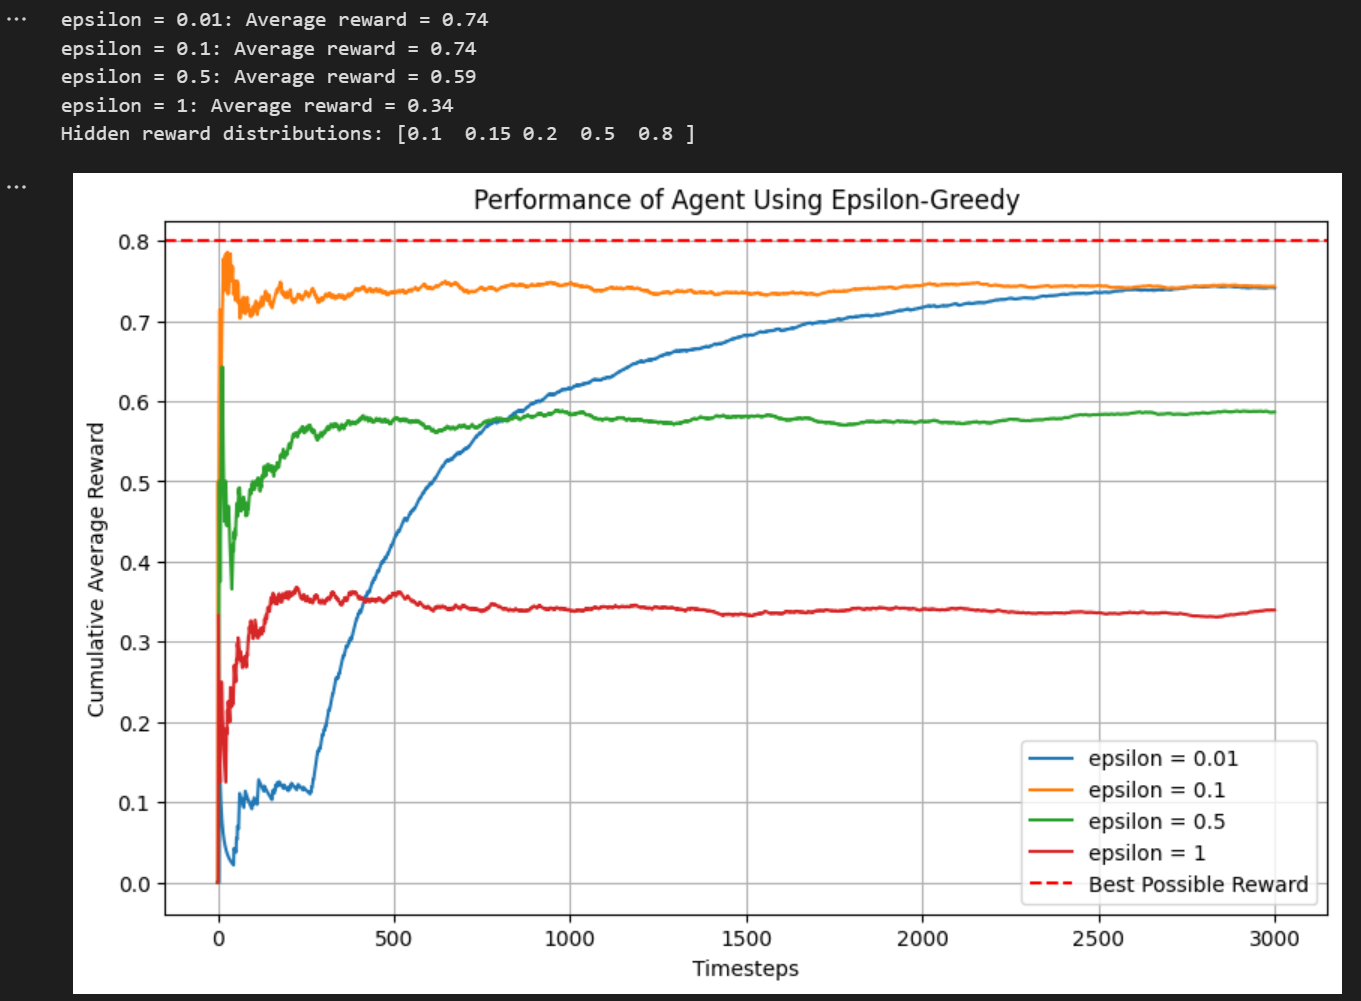

### 3rd run

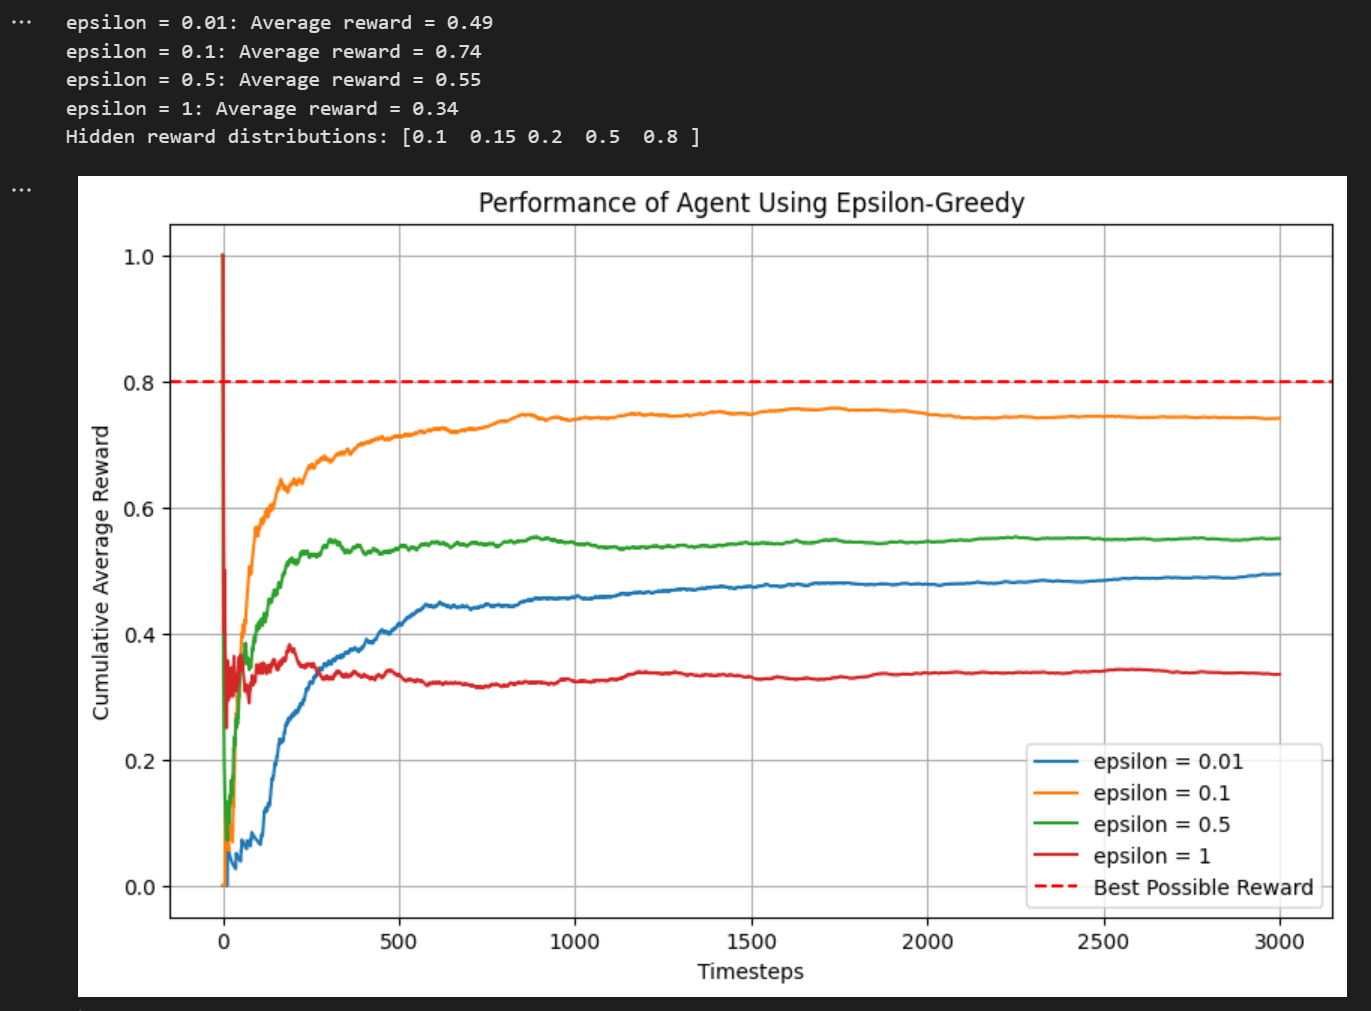

### 4th run

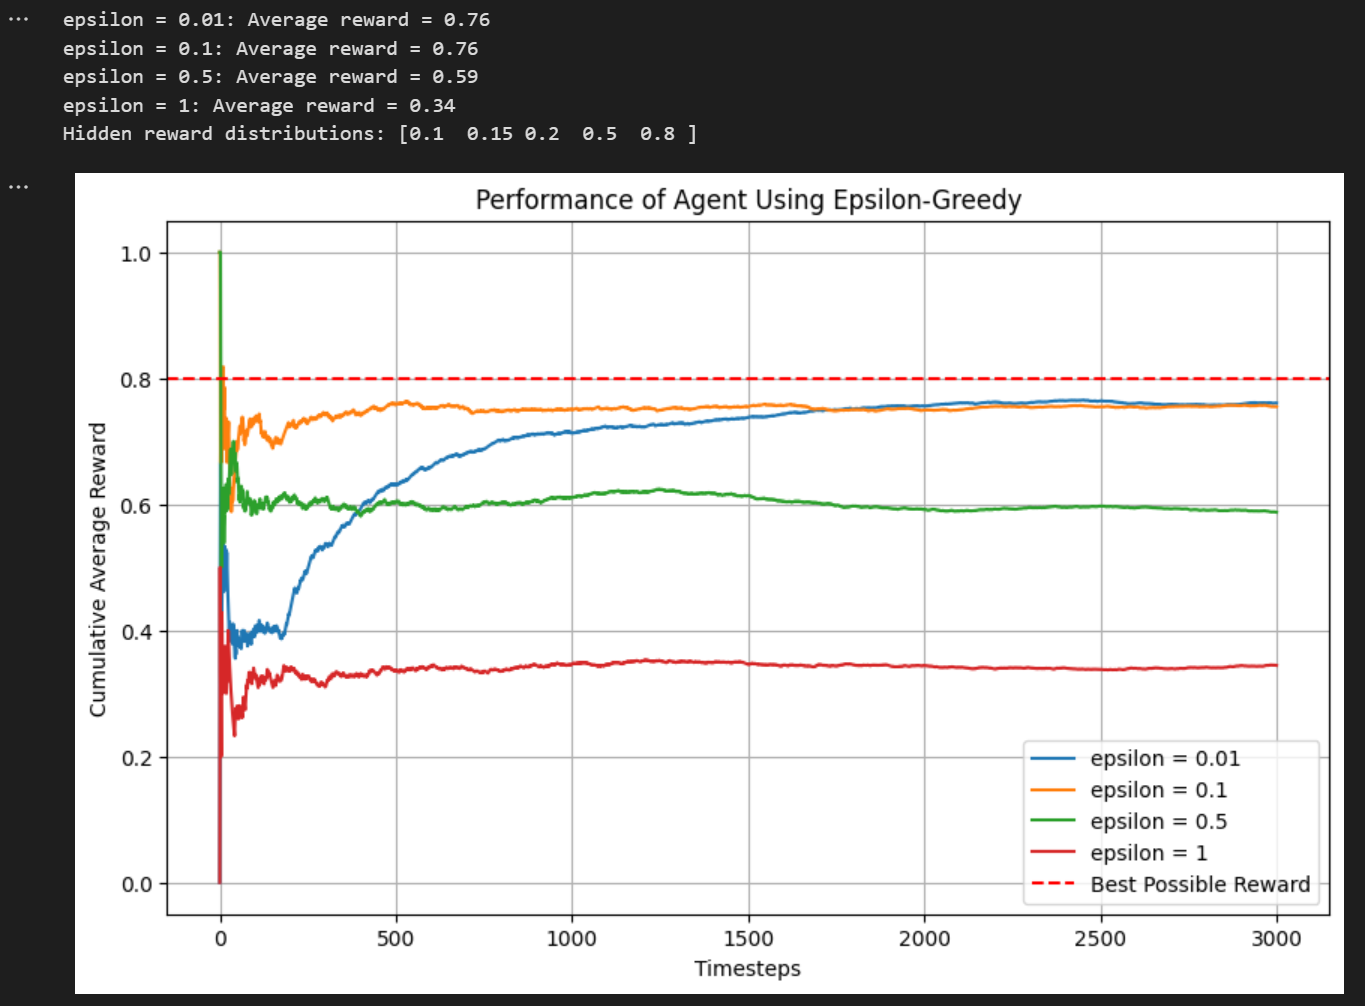

### 5th run

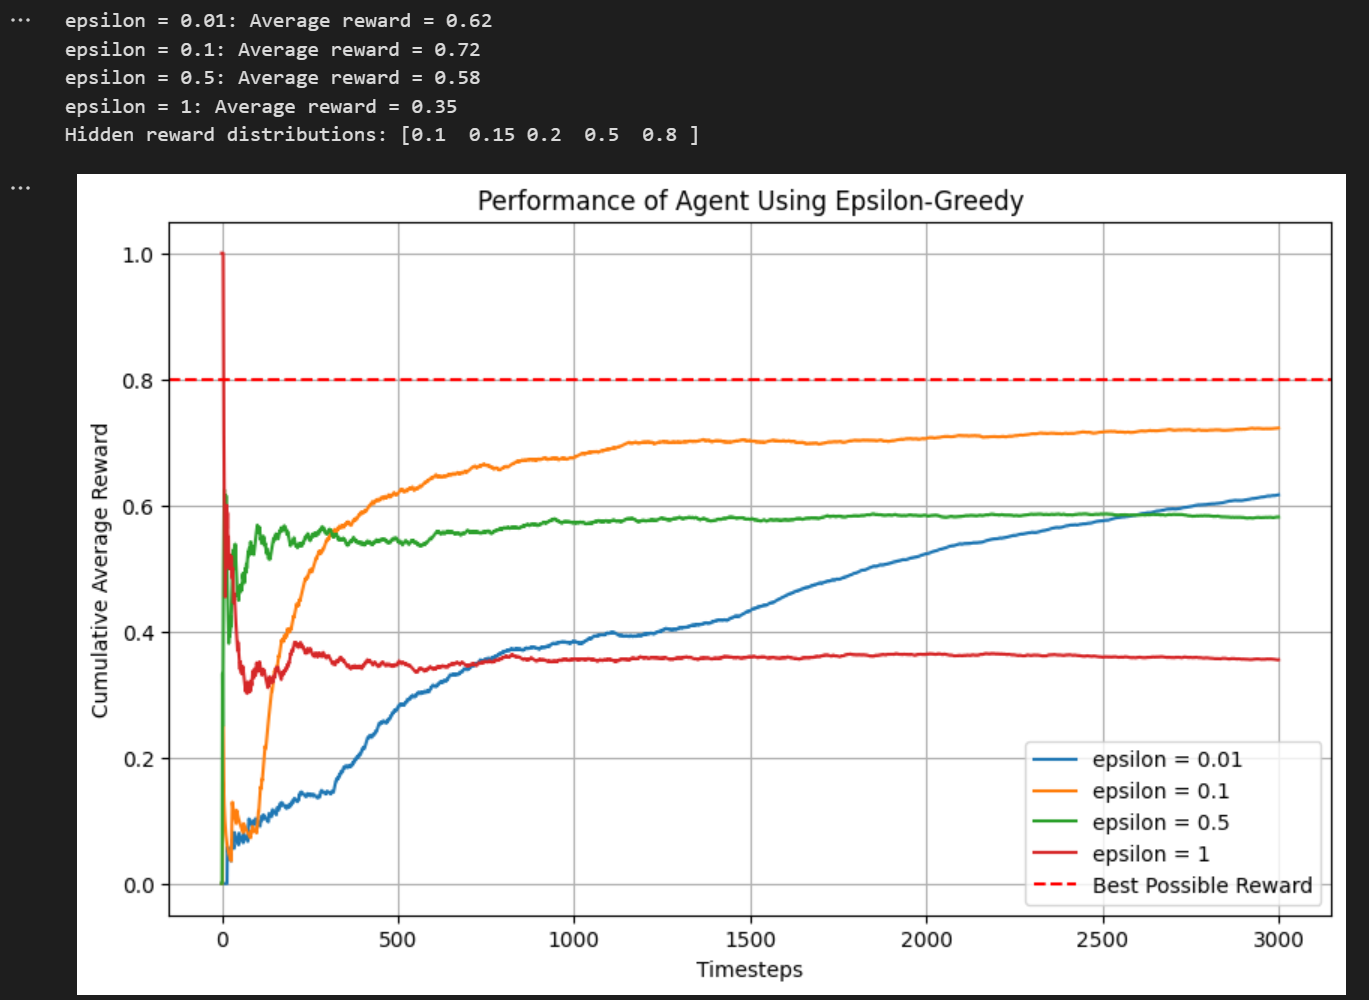

### 6th run 

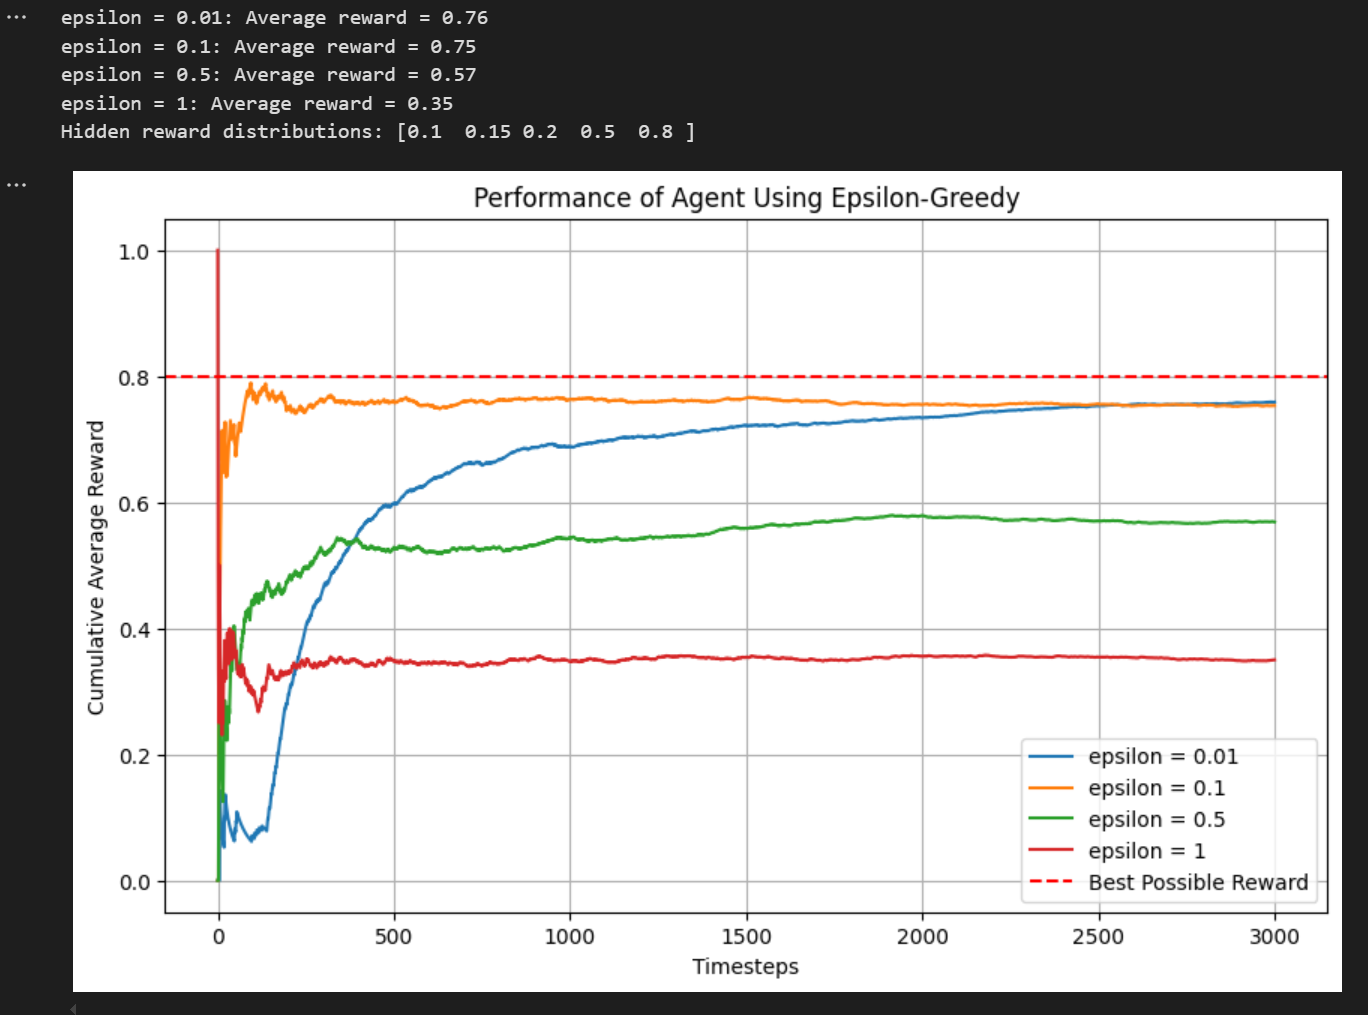

### 7th run

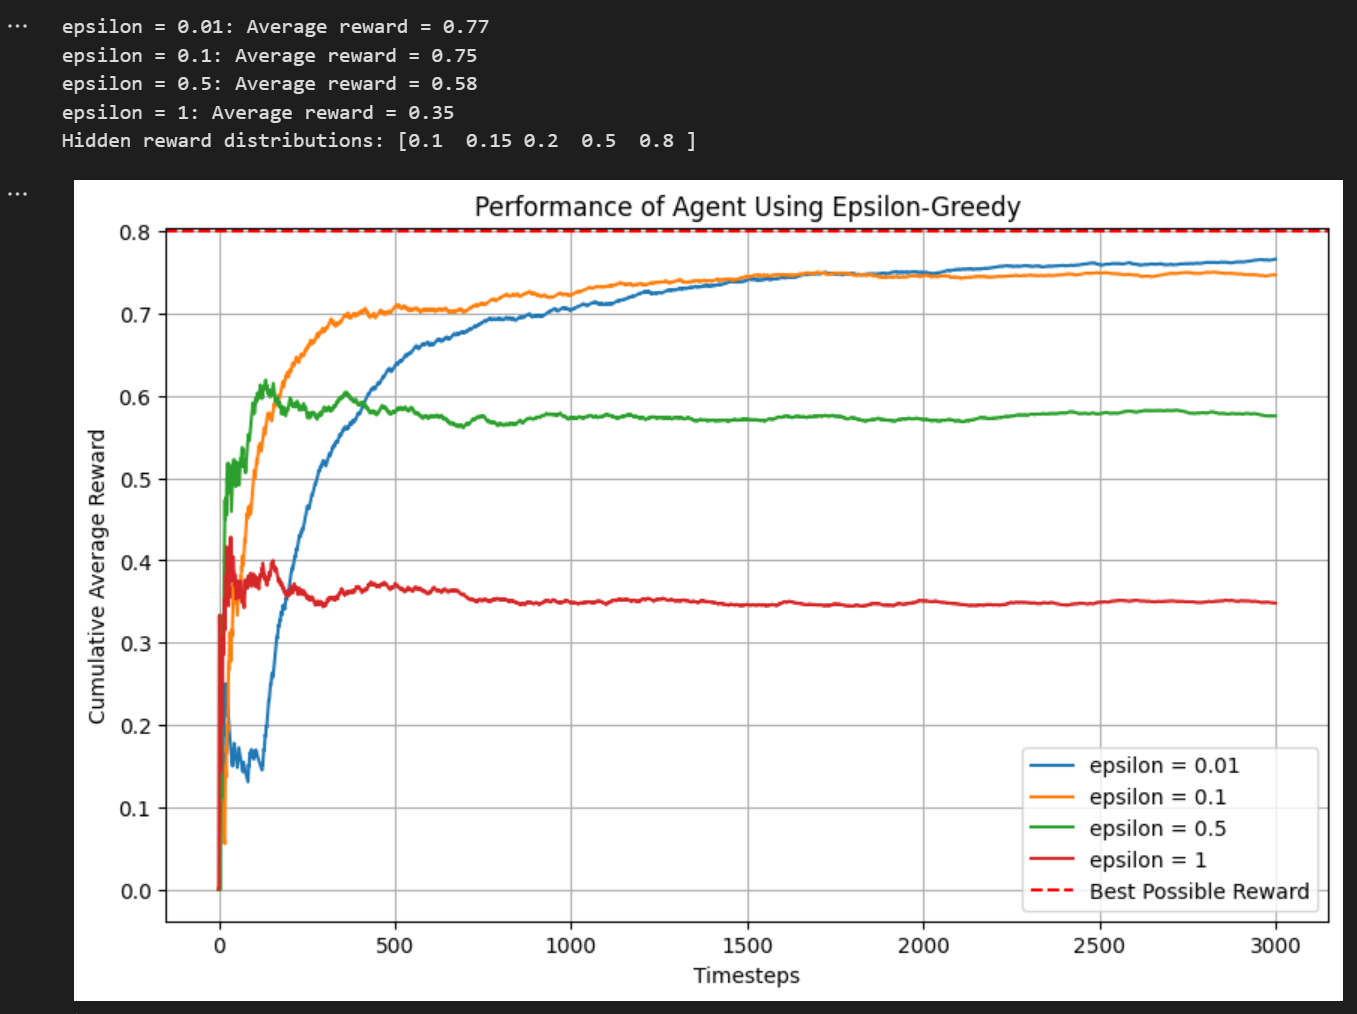

### 8th run 

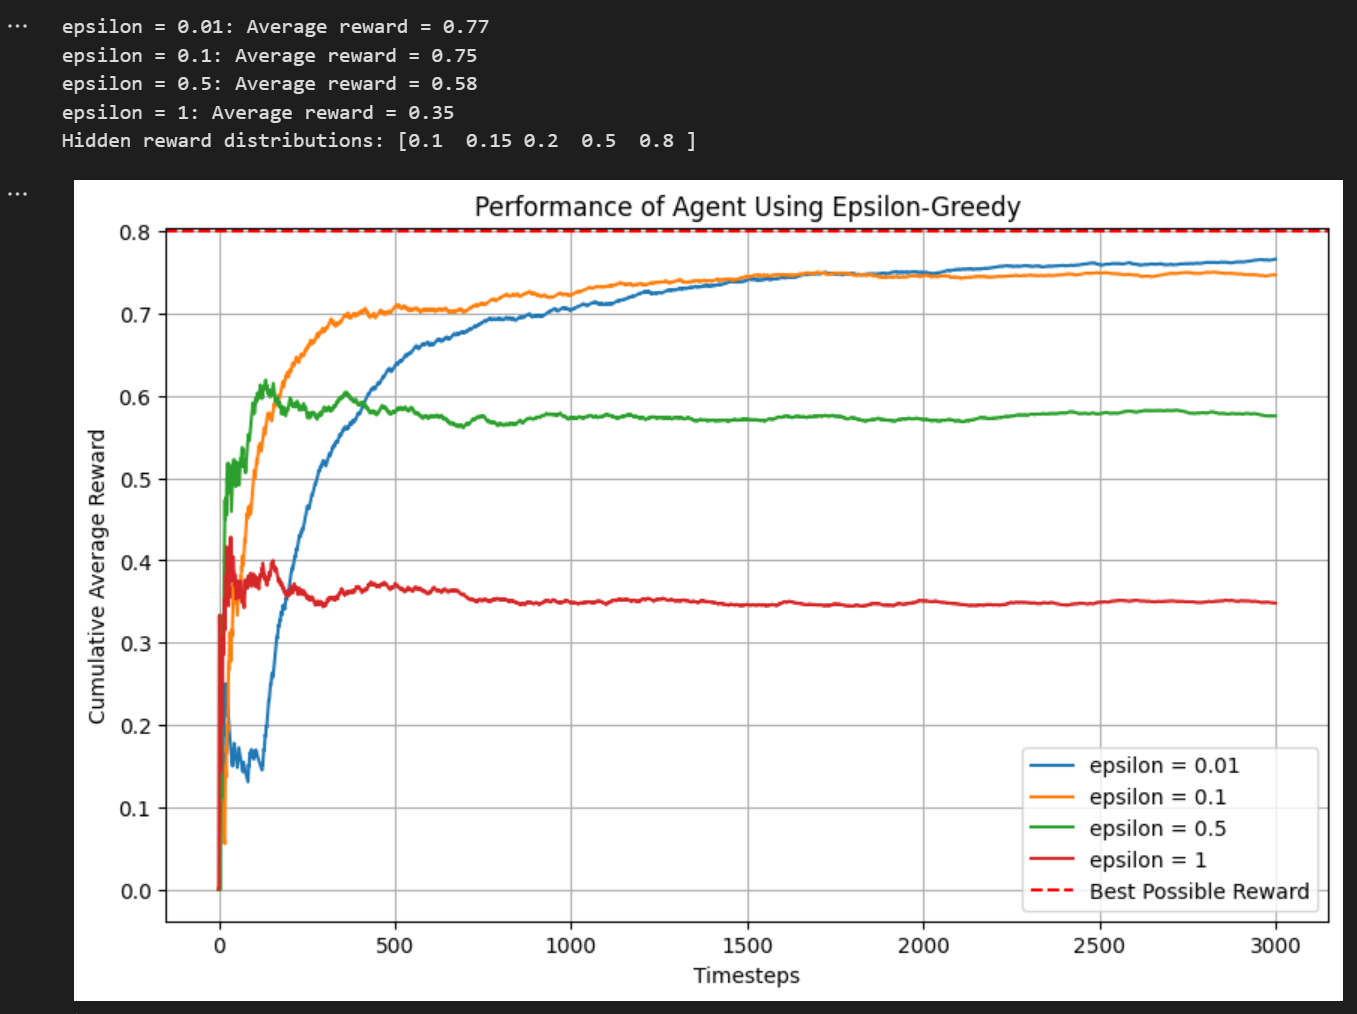

### 9th run 

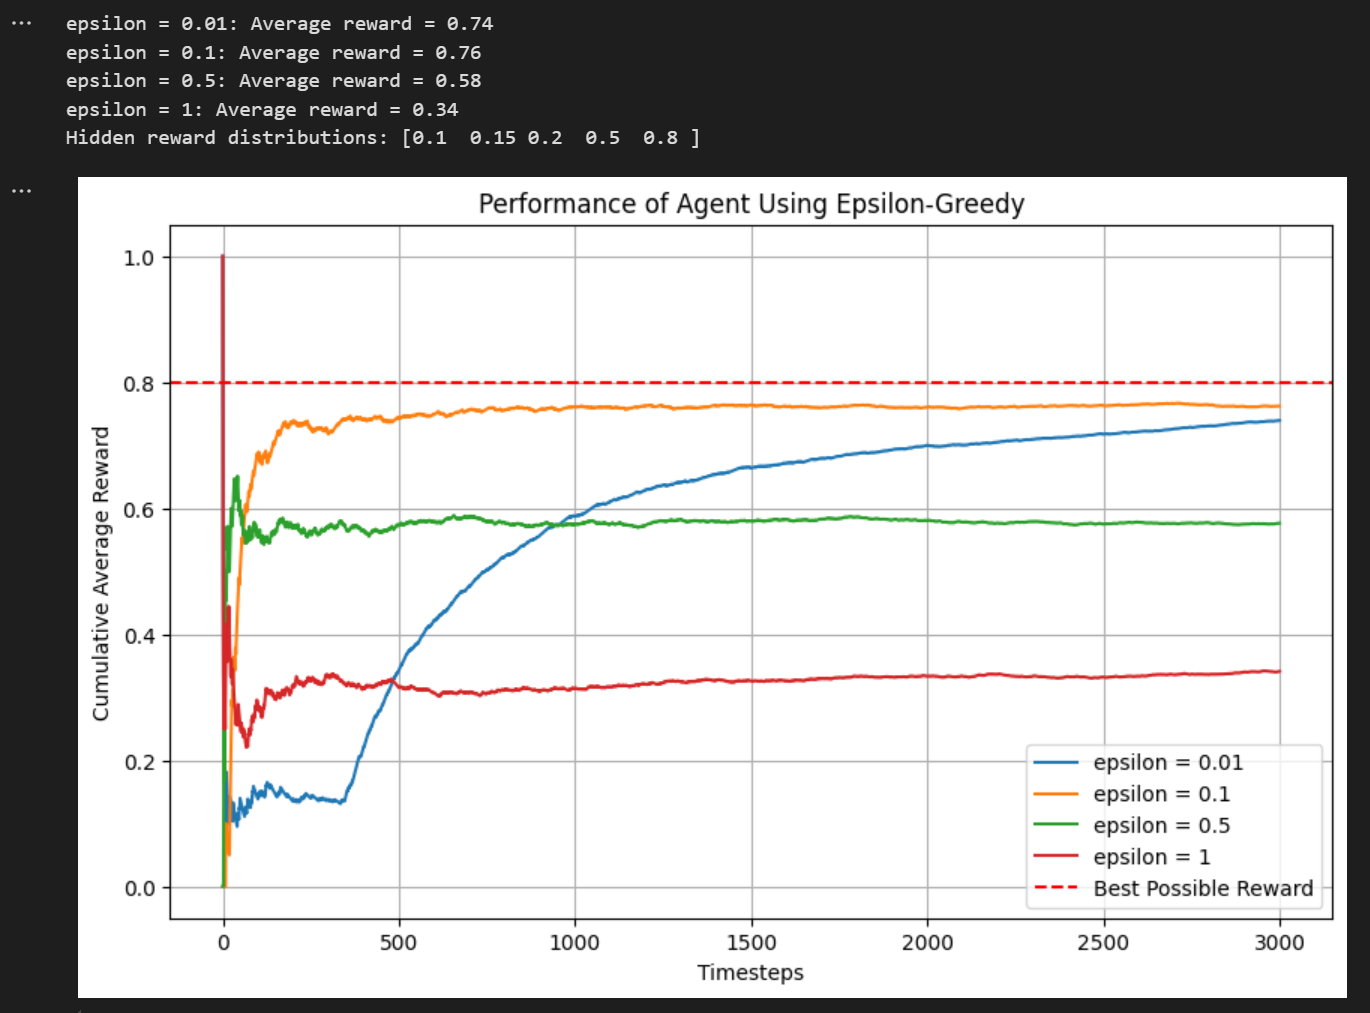

### 10th run 

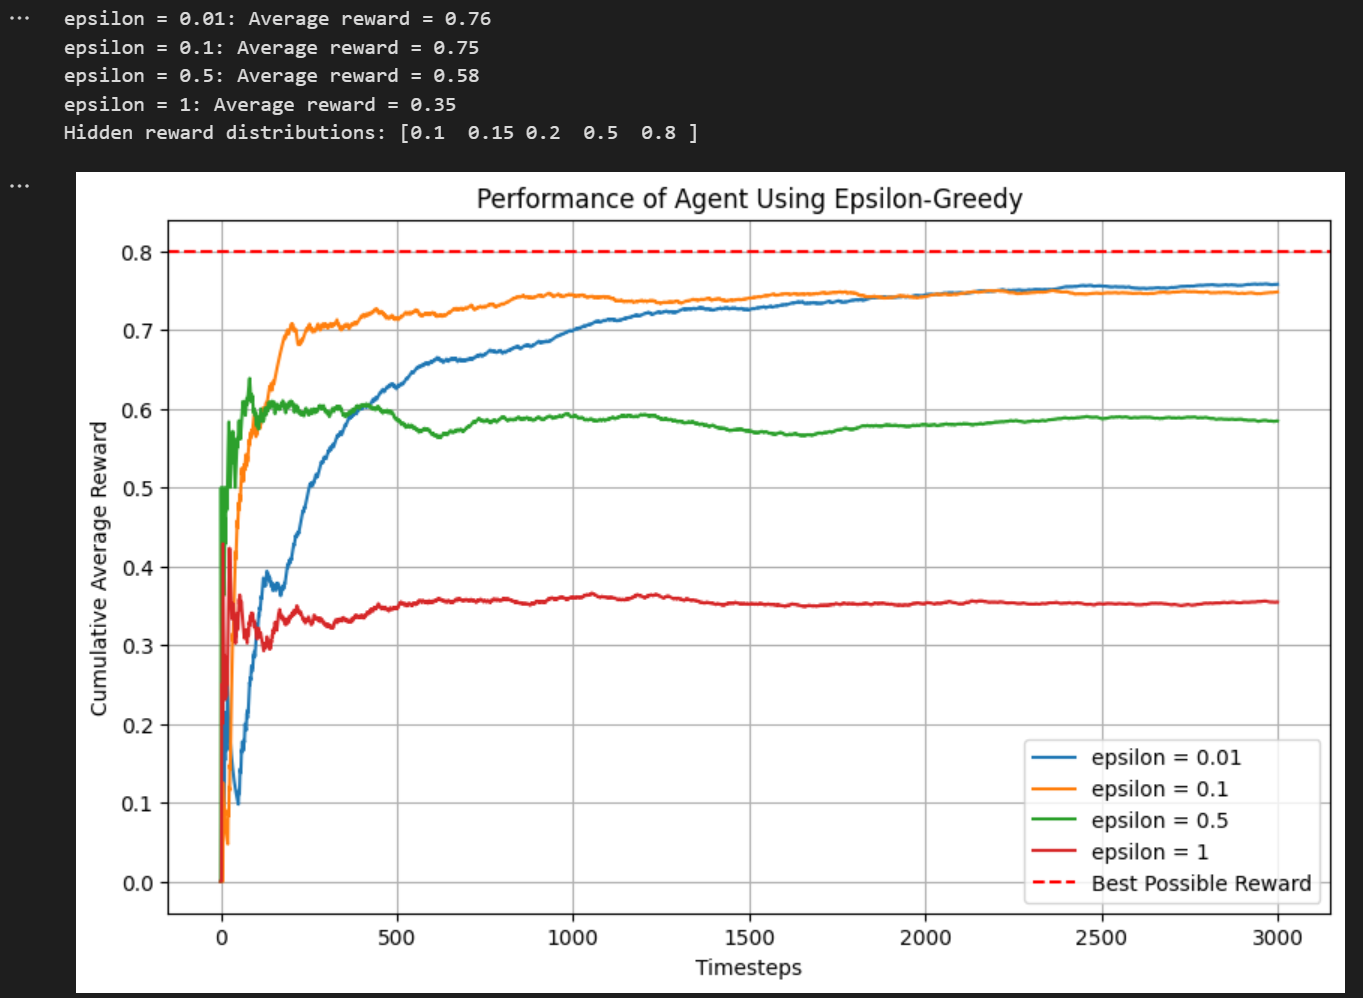

### From the experimental results, it can be observed that as the Epsilon value approaches 1, the Agent tends to explore more and exploit less. Conversely, as the value approaches 0, the Agent is able to exploit sufficiently to achieve the maximum possible reward. However, an exception is observed with Epsilon = 0.01, which does not seem to follow this trend very well, because sometimes it's not perform well (3rd run) This could be due to excessive exploitation.

## Part 3: Implementing UCB


c = 0.01: Average reward = 0.80
c = 0.1: Average reward = 0.79
c = 0.5: Average reward = 0.80
c = 1: Average reward = 0.77
c = 2: Average reward = 0.75
c = 5: Average reward = 0.62
c = 10: Average reward = 0.50
Hidden reward distributions: [0.1  0.15 0.2  0.5  0.8 ]


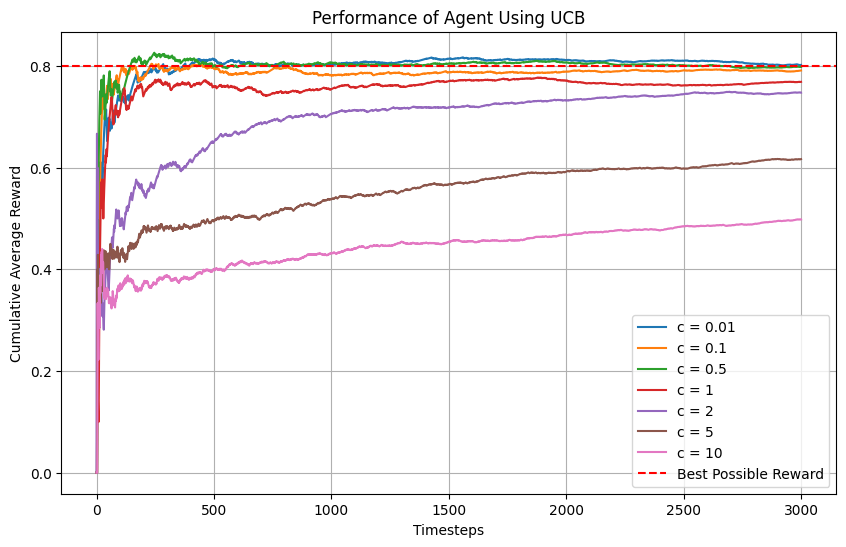

In [111]:
if __name__ == "__main__":
    cumulative_rewards_results = {}

    n_bandits = 5     # จำนวน Bandits
    n_steps = 3000    # จำนวน Timestep
    c_values = [0.01, 0.1, 0.5, 1, 2, 5, 10]
    # c_values = [-1, -0.5, -0.1, 0, 0.001, 0.01, 0.1, 0.5, 1, 2, 5]
    rewards = [0.1, 0.15, 0.2, 0.5, 0.8]

    # เลือกวิธีการทดลอง
    method = "UCB"
    
    for c in c_values:
        # รันการทดลอง
        rewards = [0.1, 0.15, 0.2, 0.5, 0.8]
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[c] = cumulative_rewards

        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    # print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    for c, cumulative_rewards in cumulative_rewards_results.items():
        plt.plot(cumulative_rewards, label=f"c = {c}")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

## Experimental 
### hypothesize
### 1. If c approaches 0, the agent will fail to explore sufficiently and may not find the most rewarded bandit.
### 2. If c approaches to infinite, the agent will continuously observe (exploit) the bandits without sufficient exploration, also failing to find the most rewarded bandit.
### Observation : We analyzed the average reward for each c value over 10 trials and observed the trend of the graph.
### 

### We conducted an experiment by running an epsilon-greedy algorithm with the following c values: [0.01, 0.1, 0.5, 1, 2, 5, 10]. Each value was tested ten times, and the rewards were fixed for five bandits with the following probabilities: [0.1, 0.15, 0.2, 0.5, 0.8]. Here are the results.

### 1st run

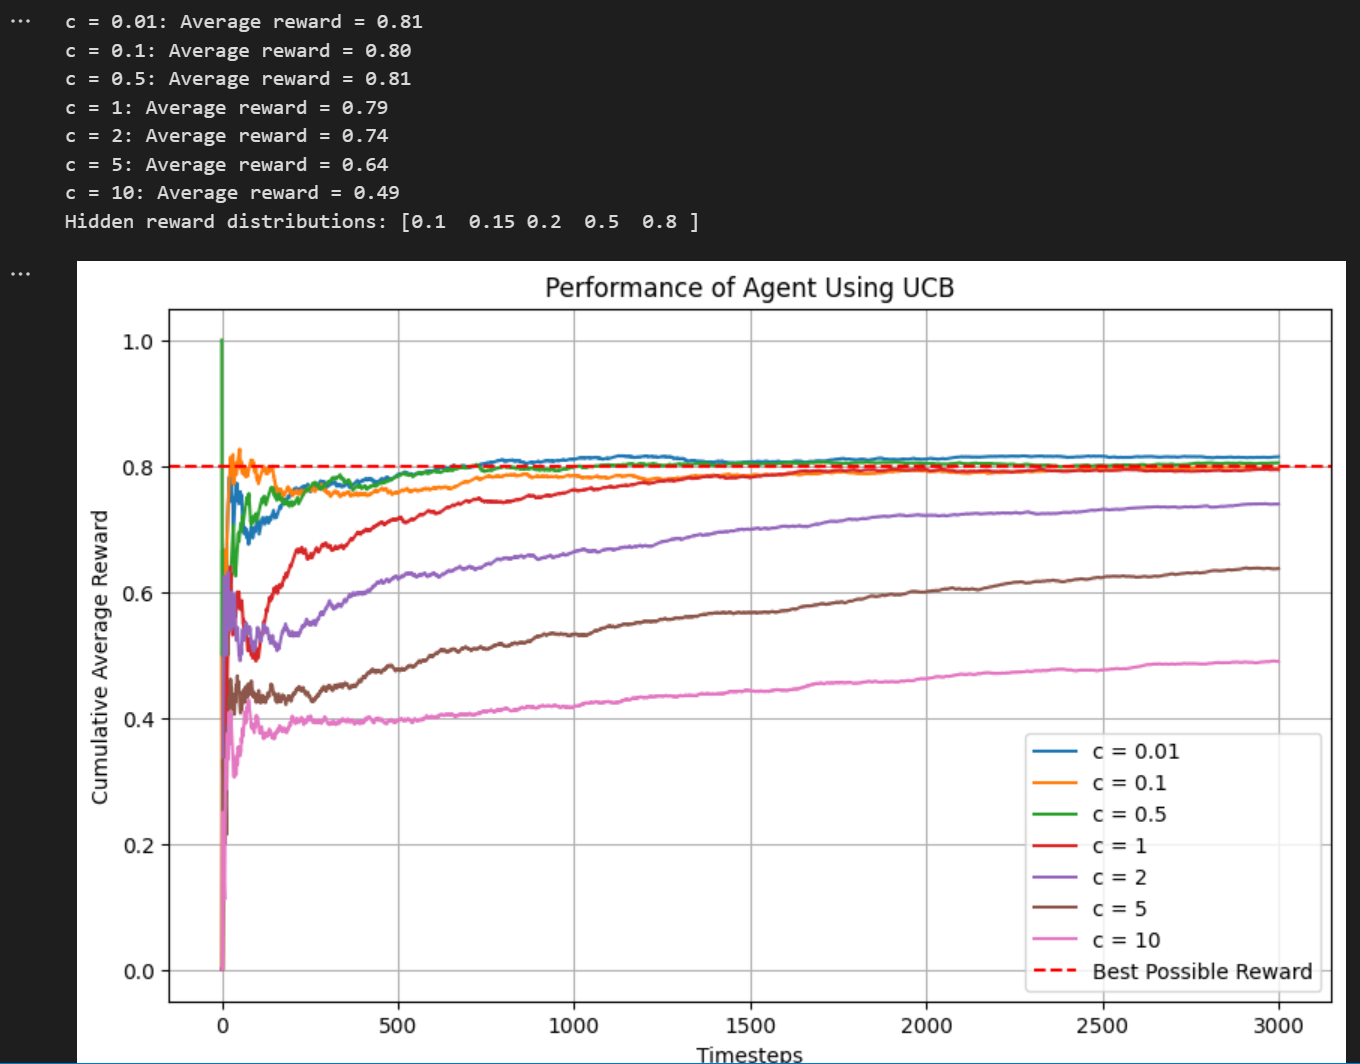

### 2nd run 

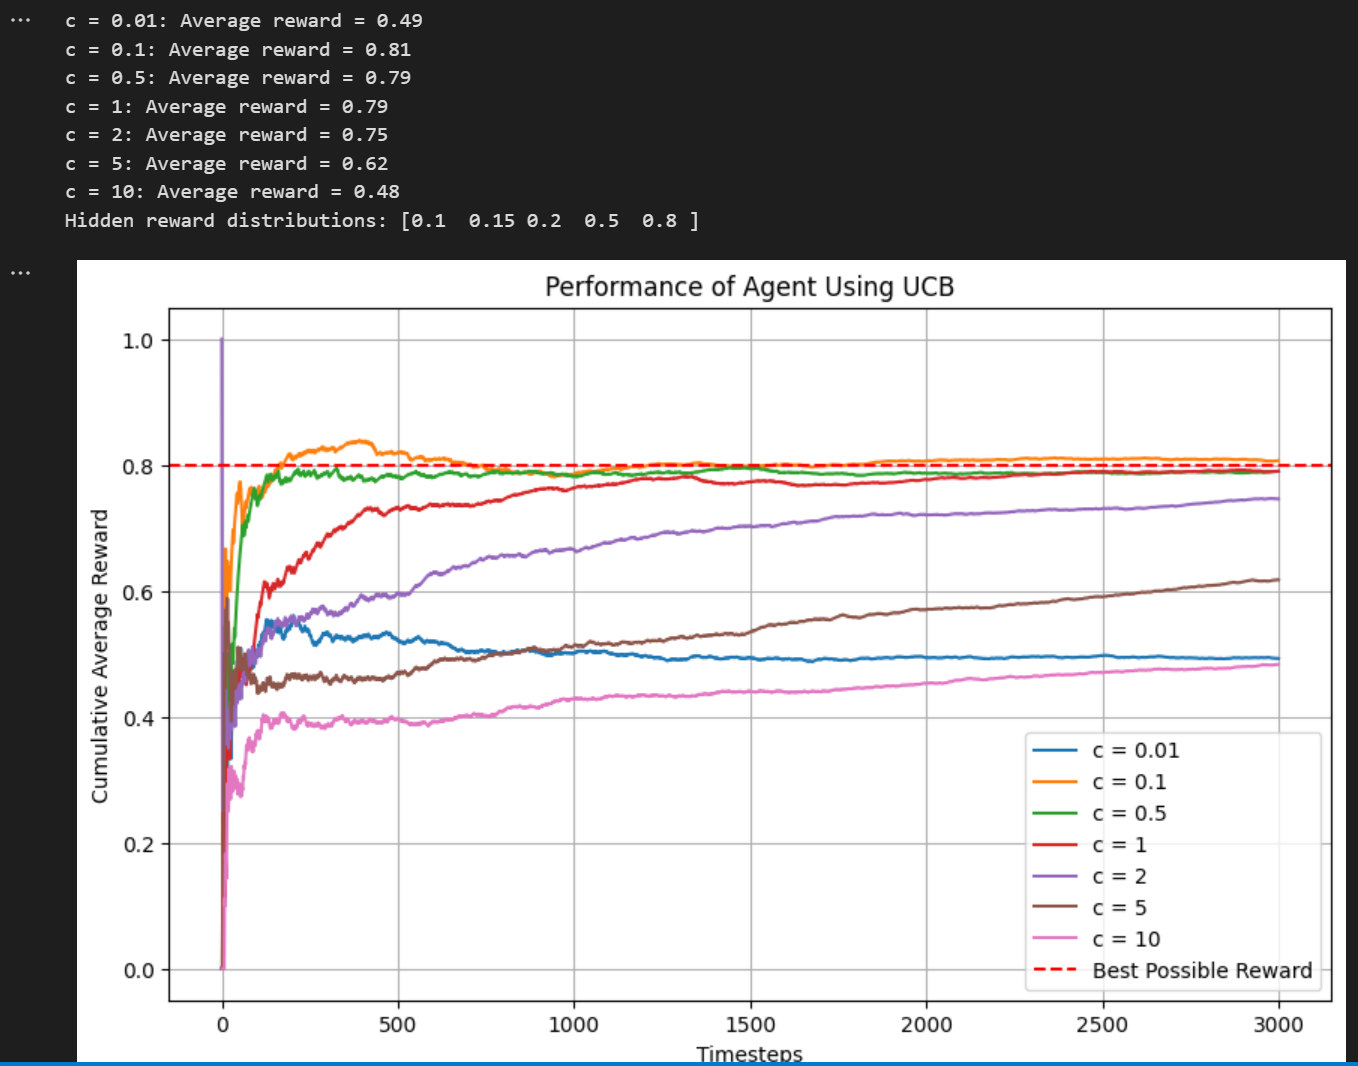

### 3rd run

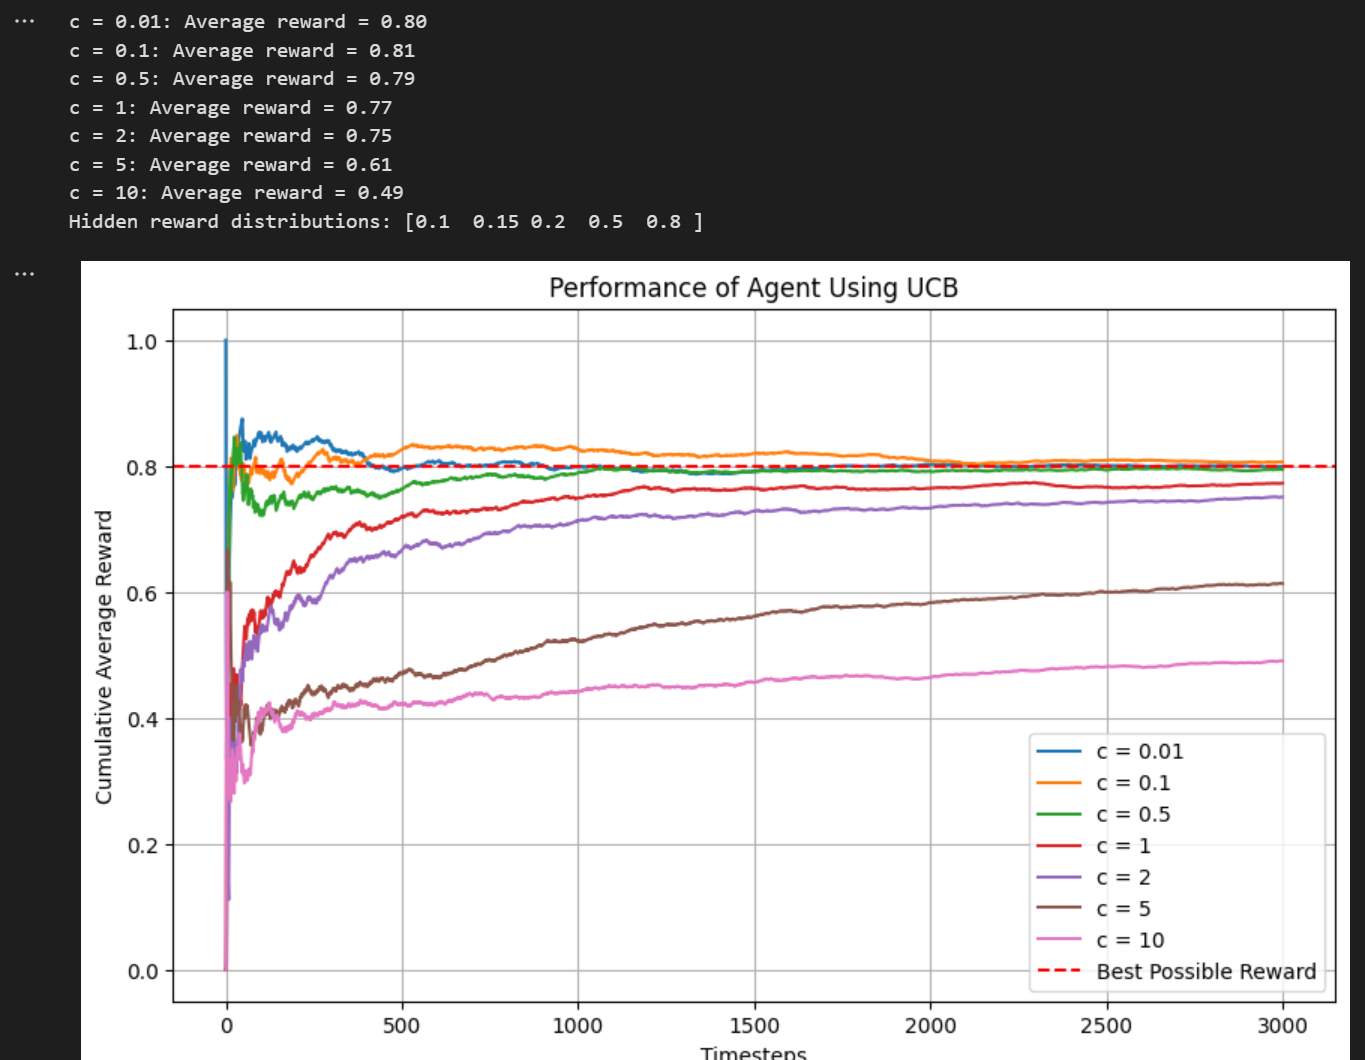

### 4th run

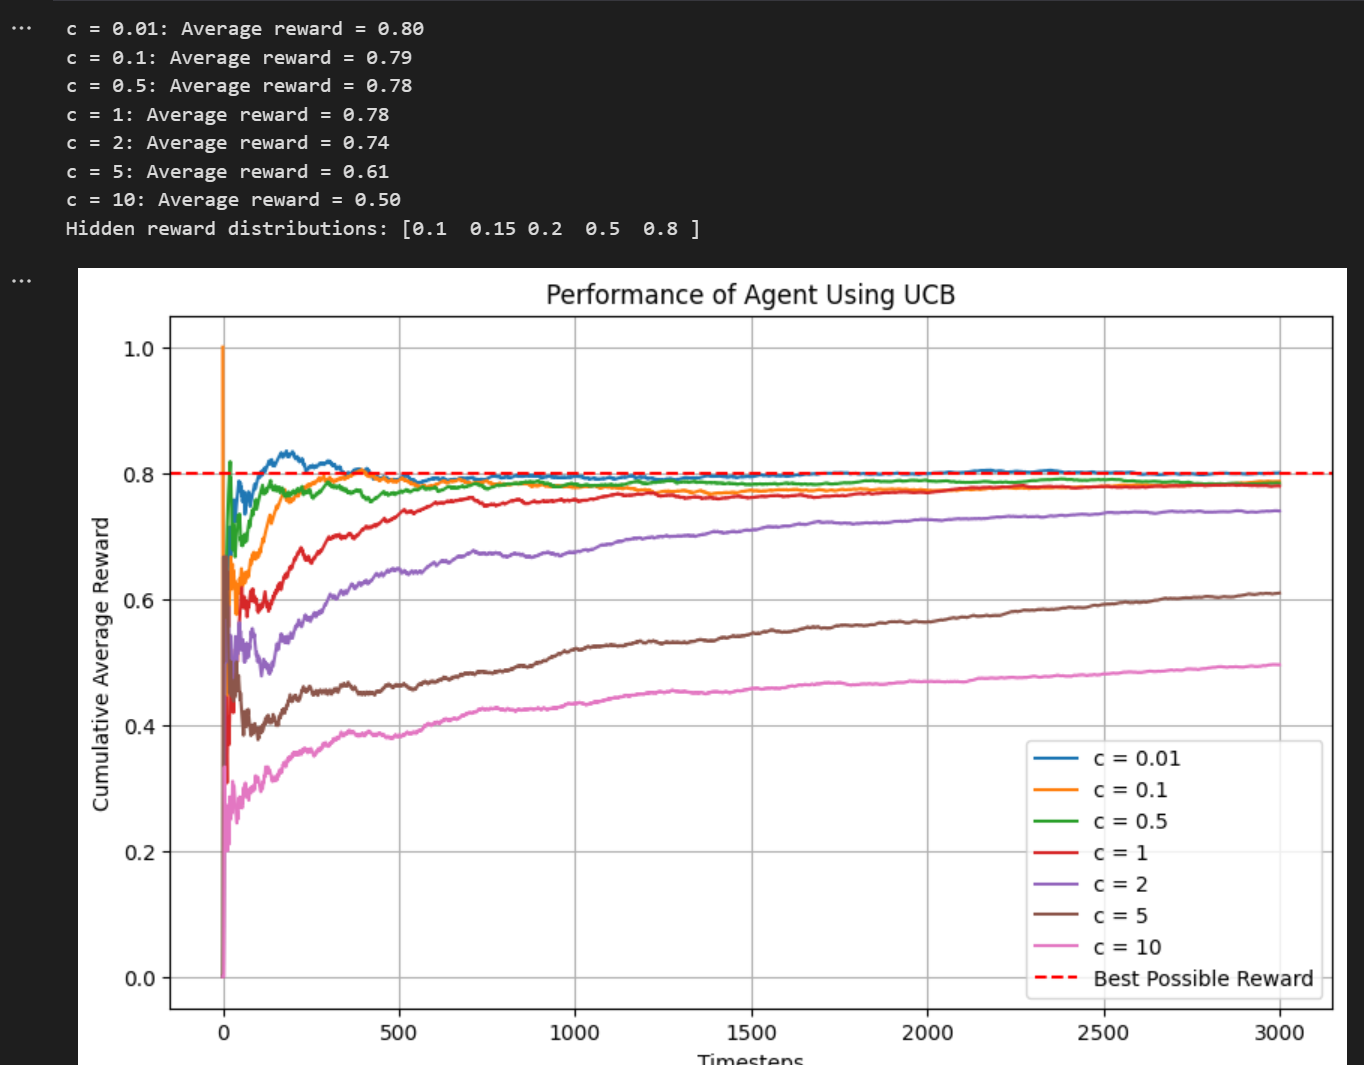

### 5th run

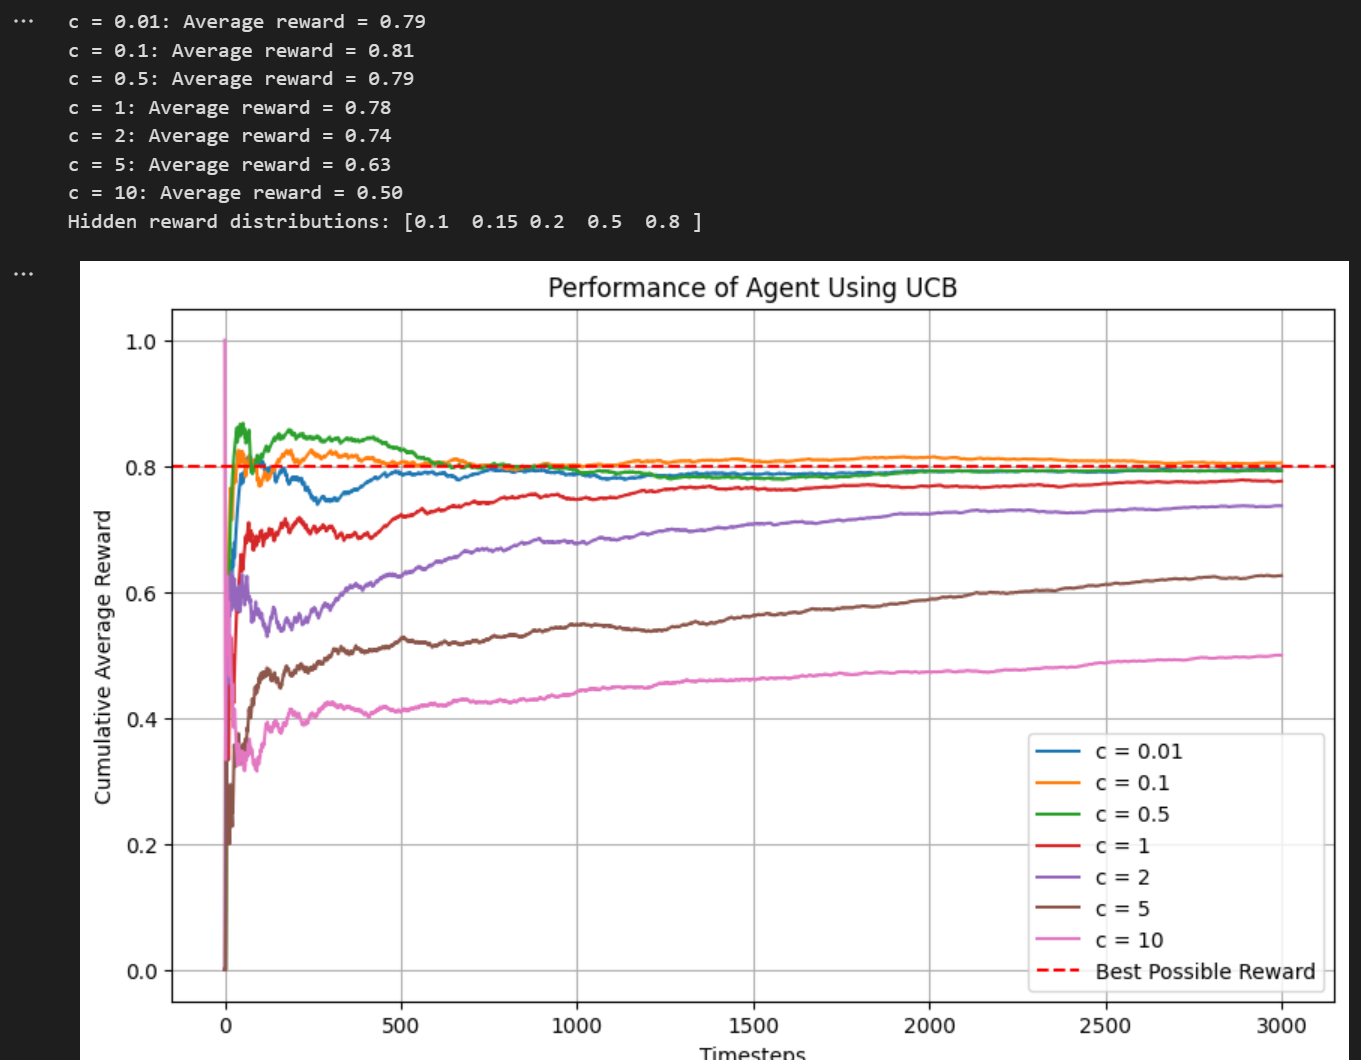

### 6th run

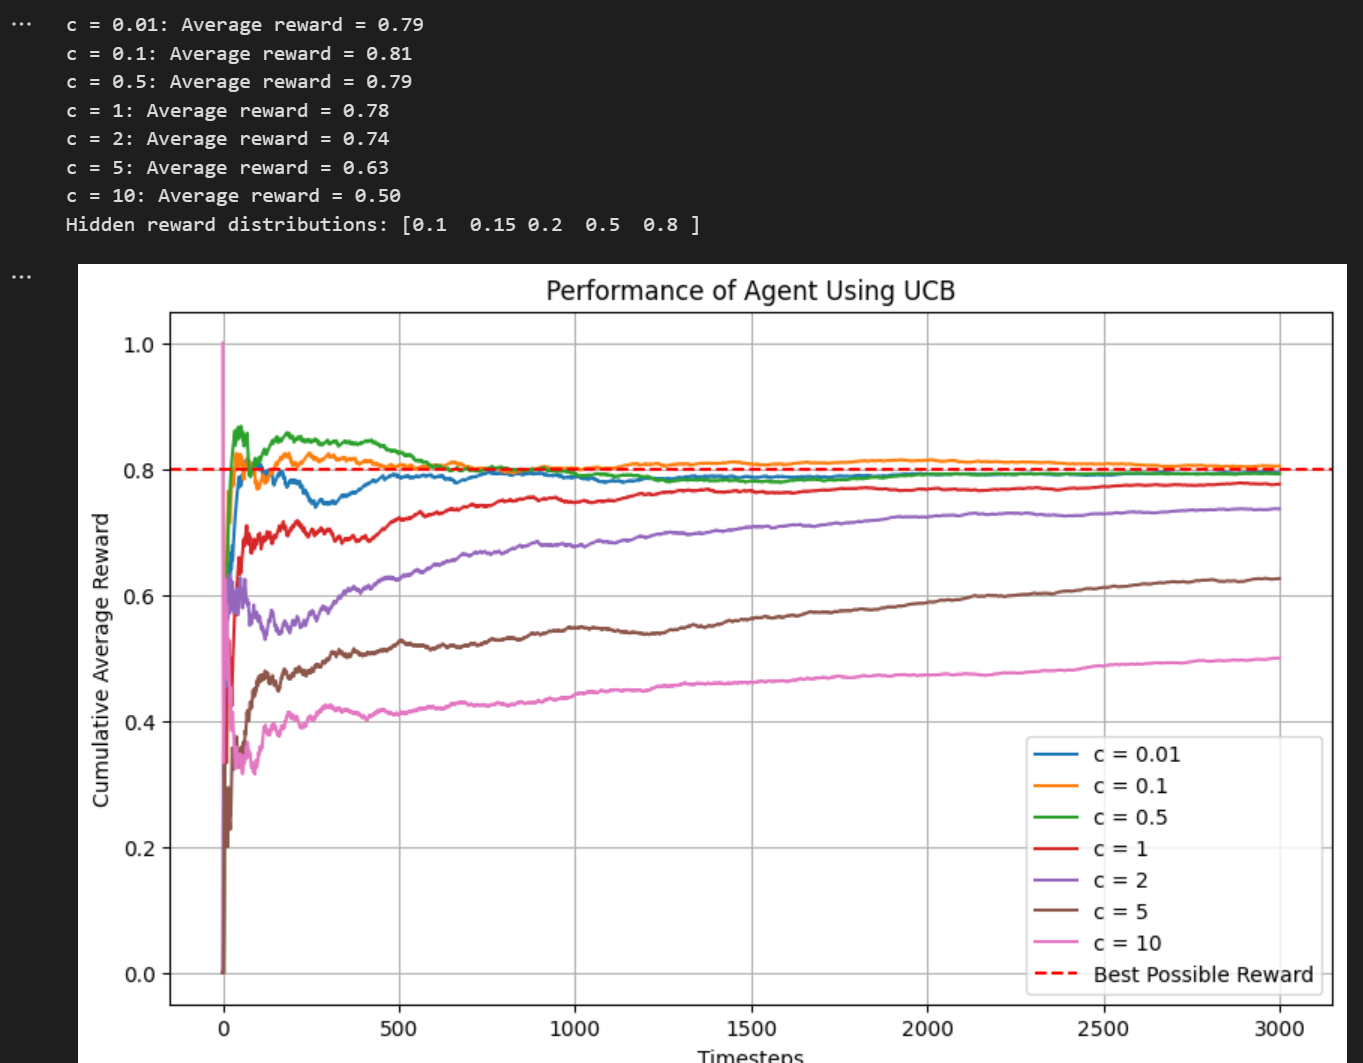

### 7th run

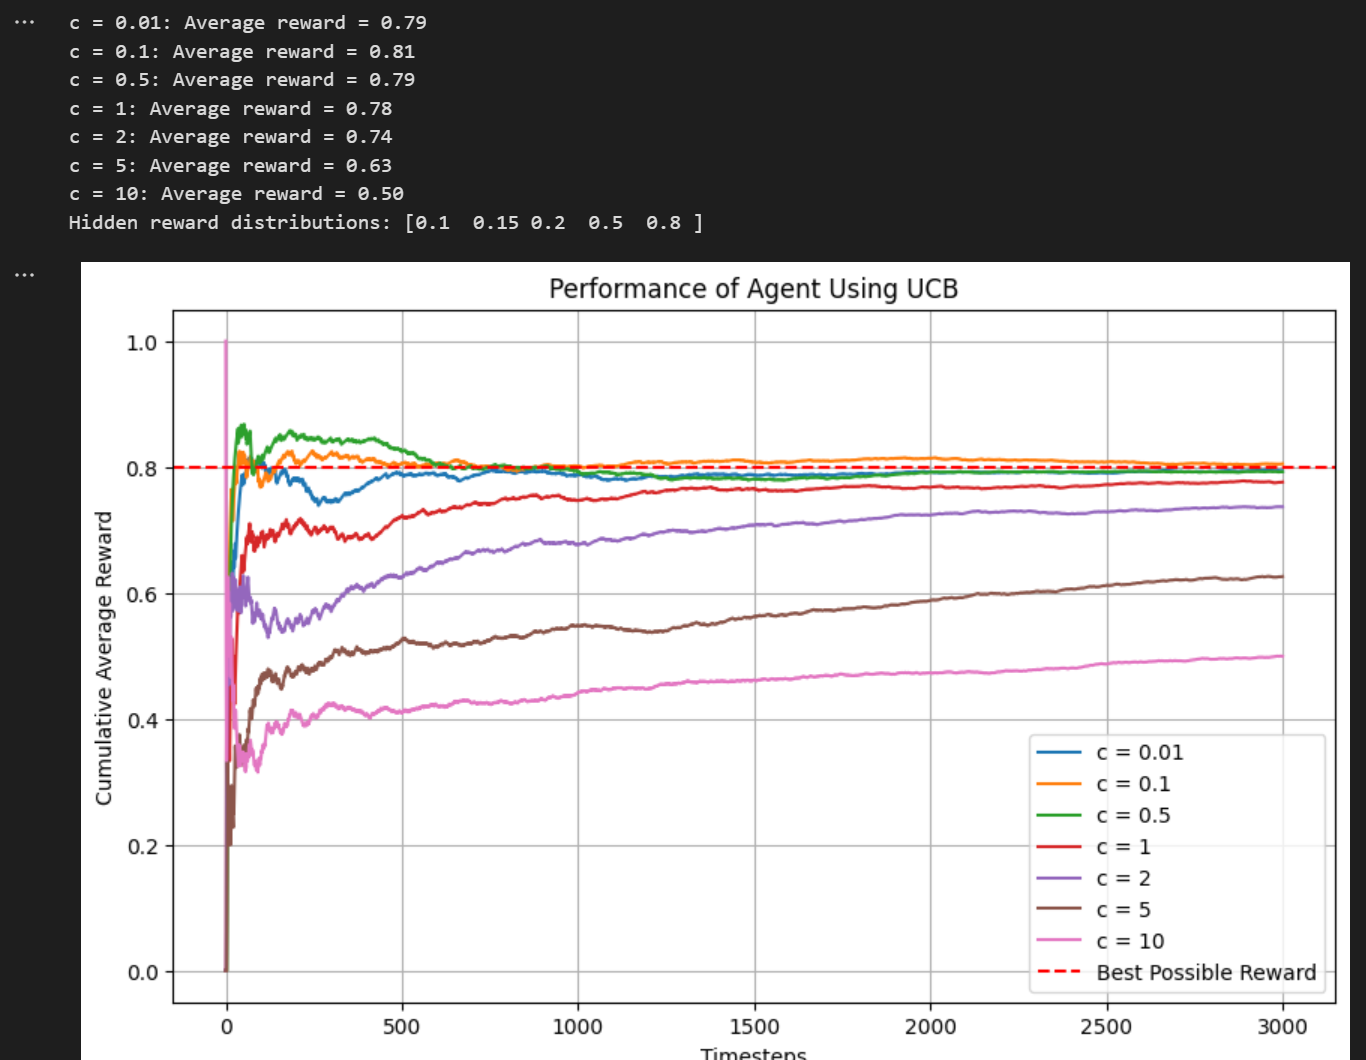

### 8th run

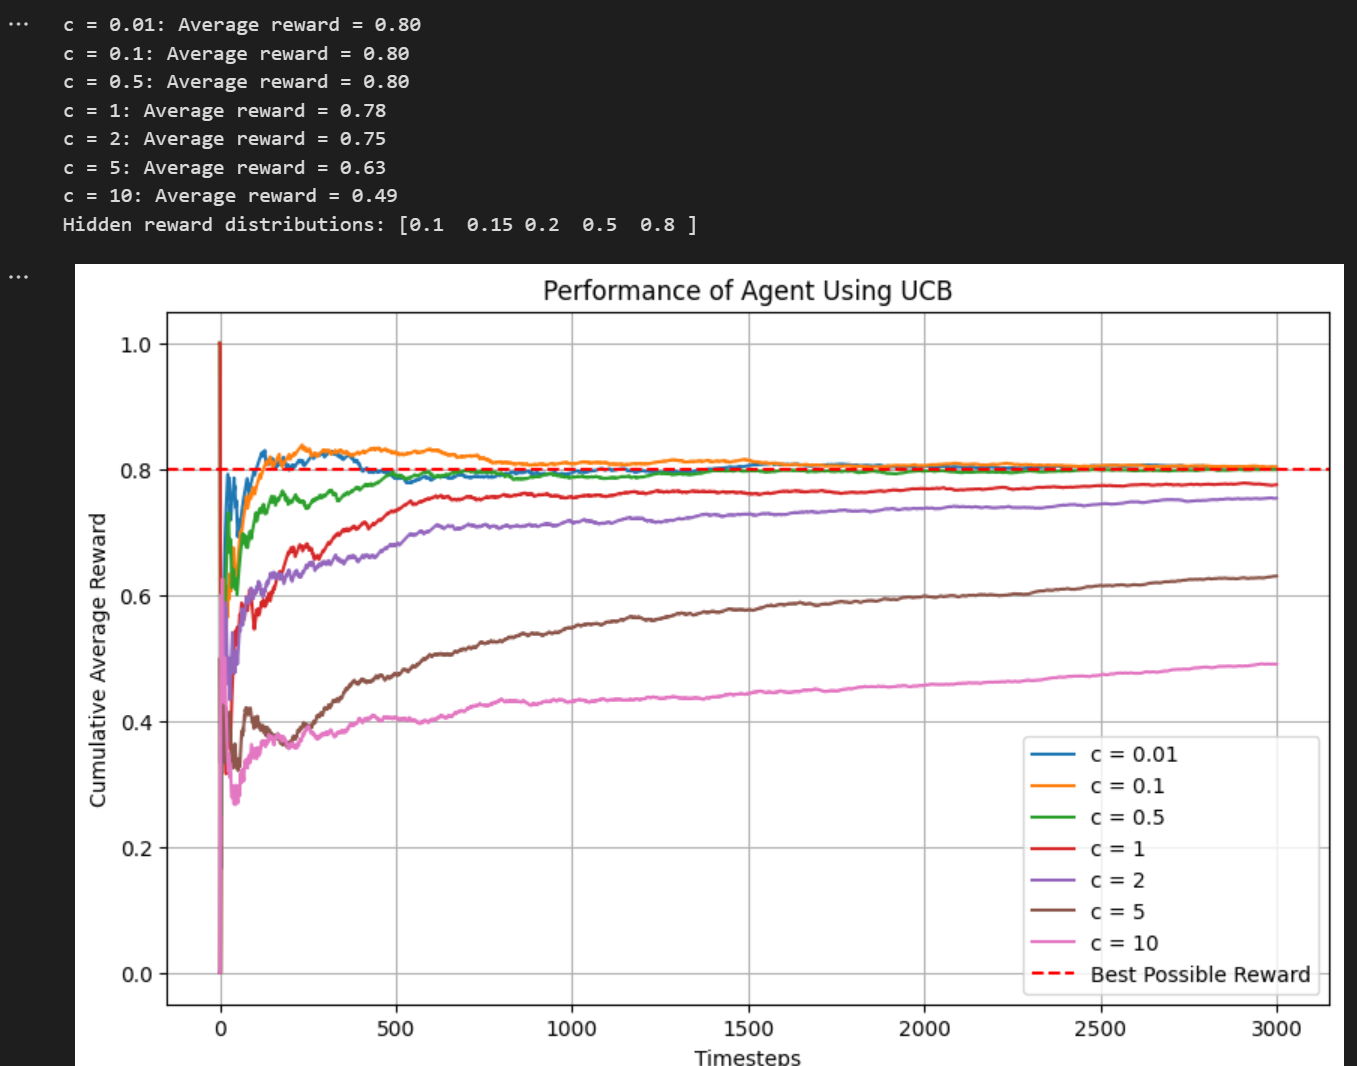

### 9th run

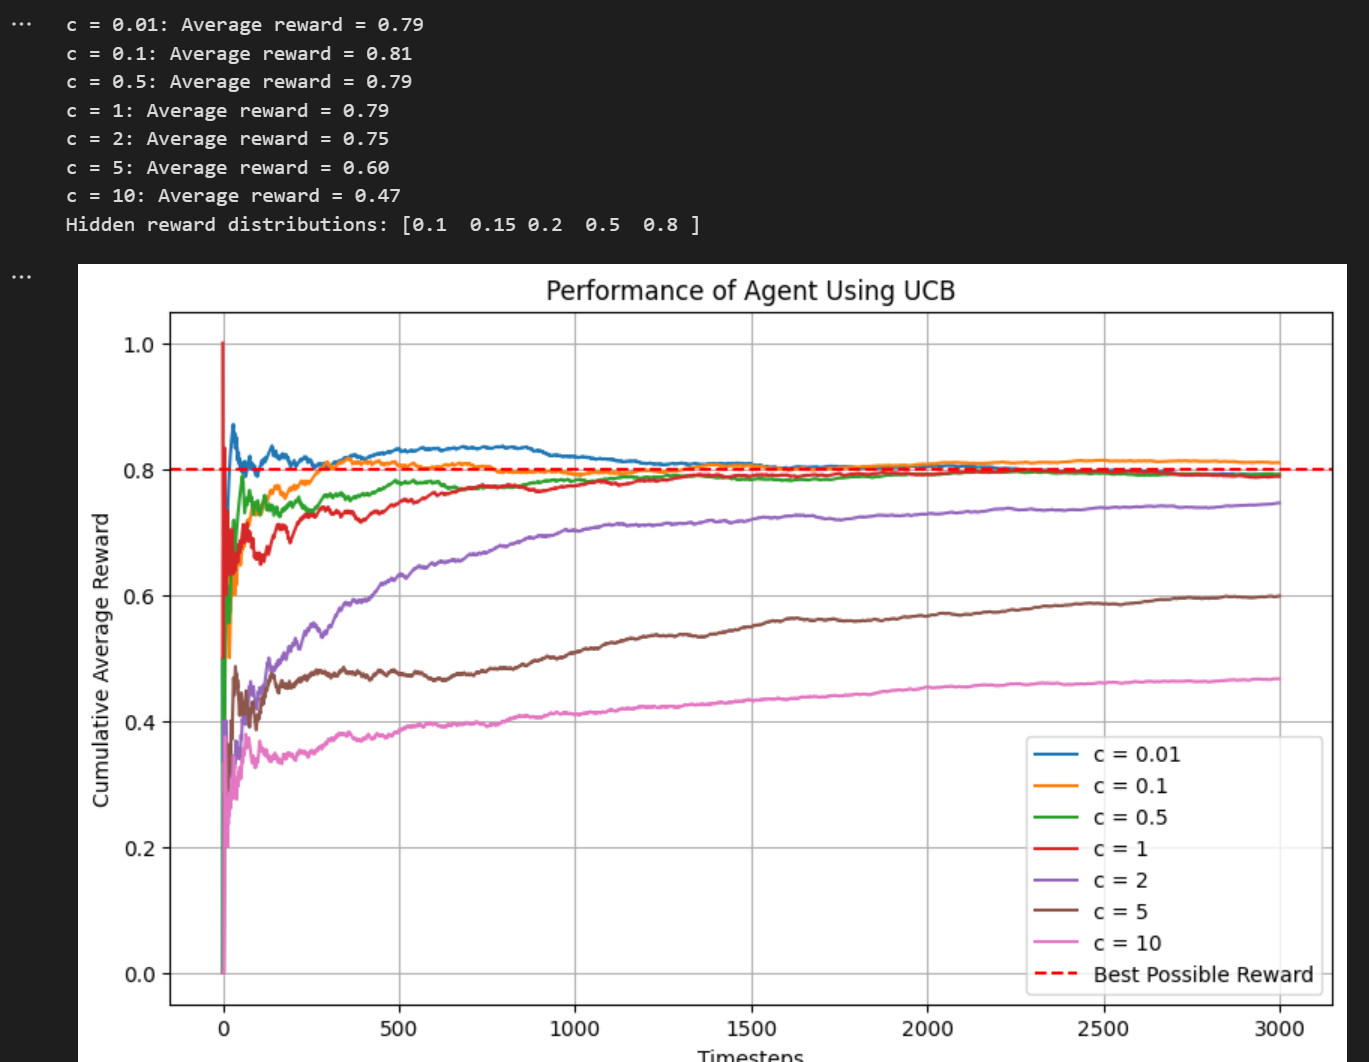

### 10th run

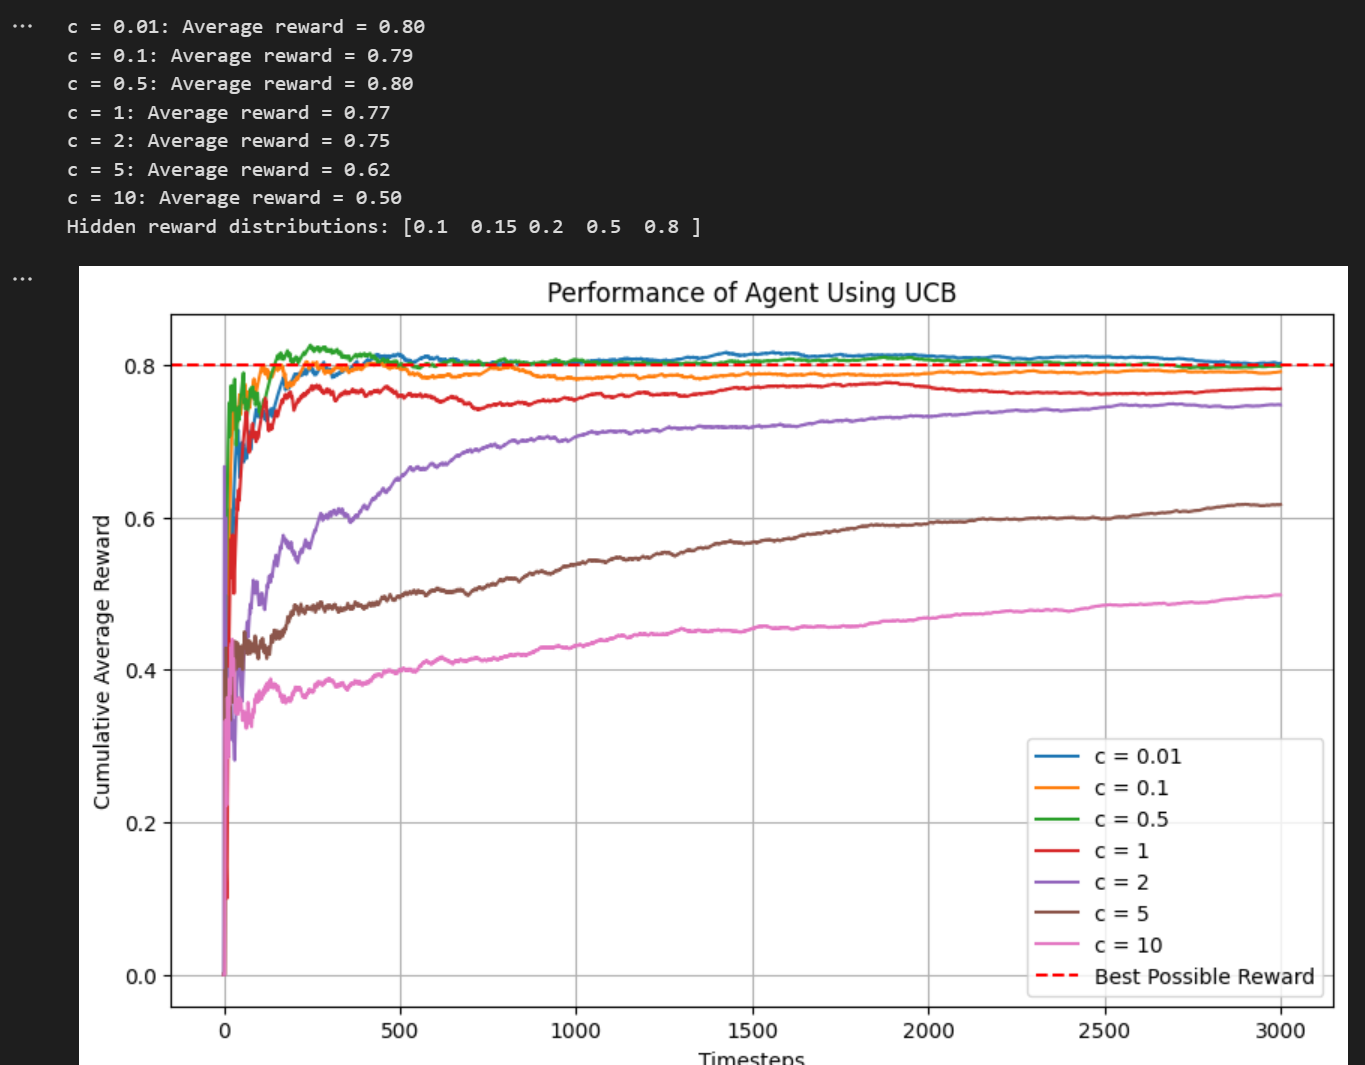

### From the experimental results, it can be observed that as the c value approaches infinite, the Agent tends to explore more and exploit less. Conversely, as the value approaches 0, the Agent is able to exploit sufficiently to achieve the maximum possible reward. However, an exception is observed with c = 0.01, which does not seem to follow this trend very well, because sometimes it's not perform well (2nd run) This could be due to excessive exploitation.

# Epsilon-Greedy VS UCB
### If we comparing epsilon-greedy and UCB results we observe that UCB achieves a higher reward and get closer to maximum possible reward compared to epsilon-greedy, and we Hypothesis that Epsilon-Greedy is uses random exploration, so it sometimes wasted time exploring a bad actions and can even when it should, it might still explore some action, but UCB if confident value is less it will exploit only so its more efficiently.